# Time series analysis of TTC sub

The objective is to create a model to predict the number of delays per day recorded on TTC subway delay datasets from the Toronto open data portal (https://open.toronto.ca/dataset/ttc-subway-delay-data/).


**Data selection and extraction**
- I selected two years worth of data as I thought it would be useful to have multiple years to explore trends
- I decided to focus on pre-pandemic data (2018, 2019) to limit any skew from the slowdowns during the COVID-19 pandemic
- Data extraction method for the data files
    - I downloaded the files for 2018 and 2019 
    - The files are in excel format with data spread across sheets. 
    - The sheets have a consistent structure but inconsistent naming convention
    - Loop through the downloaded file list and extract data from each sheet
    - Combined the data into a single dataframe
    - Export for validation and future access
- Data extraction method for the code description
    - A code dictionary was included in the TTC subway delay data set. 
    - The code dictionary is as a formatted table in an xlsx document
    - I extracted relevant rows and columns to merge with the other data

## Import packages and define notebook settings

In [1]:
#data cleaning and structure
import pandas as pd
import numpy as np
import os
from skimpy import clean_columns #clean column names
import datetime 
from itertools import product

#graphs
import seaborn as sns #a library for ploting graphs that cmplements matplot.lib
import matplotlib.pyplot as plt # library for visuals
import matplotlib as mpl

#modelling
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


## Import and clean data

In [2]:
#create a list of the filenames with data to be extracted
filenames = ["ttc-subway-delay-data-2018.xlsx", "ttc-subway-delay-data-2019.xlsx"]

#create a dummy dataframe where the data will be stored and combined
final_df = pd.DataFrame()

#loop through the files in the filename list
for file in filenames:
    #create list of all sheets in the file
    sheet = pd.ExcelFile("Data/"+file)
    myWorksheets = sheet.sheet_names
    myWorksheets
          
    #read all the sheets from the file and create a seperate excel for each year
    for sheet in myWorksheets:
        df = pd.read_excel("Data/"+file,sheet_name=sheet)
        final_df = pd.concat([final_df, df])
final_df.to_excel("Data/combined/combined.xlsx",index=False)



In [3]:
#clean the column names for the final_df
final_df = clean_columns(final_df)
final_df.head()

10 column names have been cleaned

,date,time,day,station,code,min_delay,min_gap,bound,line,vehicle
0,2018-01-01,00:29,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YU,5986
1,2018-01-01,01:07,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YU,0
2,2018-01-01,01:22,Monday,MUSEUM STATION,MUSC,0,0,N,YU,5751
3,2018-01-01,01:28,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222
4,2018-01-01,01:39,Monday,MUSEUM STATION,MUO,6,11,S,YU,5781


In [4]:
#code dictionary data 
#ignore the extra rows and colums that aren't needed in the excel sheet
delay_raw = pd.read_excel("Data/ttc-subway-delay-codes.xlsx", header=1, usecols=[2,3,6,7])

#clean column names
delay_raw = clean_columns(delay_raw)

#reorganize the data in the excel sheet into two columns
sub_rmenu = delay_raw.iloc[:,[0,1]].rename(columns={'sub_rmenu_code':'code'})
srt_rmenu = delay_raw.iloc[:,[2,3]].rename(columns={'srt_rmenu_code':'code', 'code_description_1':'code_description'})

#add a column for the type of vehicle, which was previously shown by the different columns
sub_rmenu['v_type'] = 'sub'
srt_rmenu['v_type'] = 'sub'

delay = pd.concat([sub_rmenu, srt_rmenu])
delay.head()

4 column names have been cleaned

,code,code_description,v_type
0,EUAC,Air Conditioning,sub
1,EUAL,Alternating Current,sub
2,EUATC,ATC RC&S Equipment,sub
3,EUBK,Brakes,sub
4,EUBO,Body,sub


In [5]:
#different codes mean the same thing for the subway and the scarborough rapid transit 
#so join the code description to the final df, that way you can group on the different values
final_df = final_df.merge(delay.iloc[:,[0,1]], how='left', on='code')
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39959 entries, 0 to 39958
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              39959 non-null  datetime64[ns]
 1   time              39959 non-null  object        
 2   day               39959 non-null  object        
 3   station           39959 non-null  object        
 4   code              39959 non-null  object        
 5   min_delay         39959 non-null  int64         
 6   min_gap           39959 non-null  int64         
 7   bound             30879 non-null  object        
 8   line              39808 non-null  object        
 9   vehicle           39959 non-null  int64         
 10  code_description  39135 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 3.7+ MB


*Additional cleaning and formatting*
- the time column is an hour/min column but is formatted as a string.  Convert it to datetime
- the vehicle column is an integer, but it actually represents a code for a vehicle or station
- set up day as categorical with an order

In [6]:
# time of day 
final_df['time'] = pd.to_datetime(final_df['time'],format='%H:%M').dt.strftime("%H:%M")

#convert vehicle to a code. It reflects a particular train and shouldn't be considered an integer
final_df['vehicle'] = final_df['vehicle'].astype(str)

# set categorical order
final_df['day'] = pd.Categorical(final_df['day'],
                                   categories=['Monday', 
                                               'Tuesday', 
                                               'Wednesday', 
                                               'Thursday', 
                                               'Friday',
                                               'Saturday', 
                                               'Sunday'],
                                   ordered=True)

In [7]:
final_df.shape

(39959, 11)

In [8]:
final_df.isna().sum()

date                   0
time                   0
day                    0
station                0
code                   0
min_delay              0
min_gap                0
bound               9080
line                 151
vehicle                0
code_description     824
dtype: int64

In [9]:
final_df[final_df['line'].isna()]

,date,time,day,station,code,min_delay,min_gap,bound,line,vehicle,code_description
64,2018-01-02,02:02,Tuesday,WARDEN STATION,TUSC,0,0,W,NaN,5248,Operator Overspeeding
429,2018-01-08,05:59,Monday,GREENWOOD YARD,PUMO,0,0,NaN,NaN,0,Station Other
636,2018-01-11,05:23,Thursday,FINCH STATION,PUMEL,0,0,NaN,NaN,0,Escalator/Elevator Incident
892,2018-01-15,14:13,Monday,YONGE BD STATION,MUIS,0,0,W,NaN,0,Injured or ill Customer (In Station) - Transpo...
899,2018-01-15,16:57,Monday,WILSON CARHOUSE,MUO,0,0,NaN,NaN,0,Miscellaneous Other
1208,2018-01-19,22:15,Friday,GREENWOOD CARHOUSE,PUMO,0,0,NaN,NaN,0,Station Other
1365,2018-01-23,07:29,Tuesday,SUBWAY OPS BUILDING,PUMEL,0,0,NaN,NaN,0,Escalator/Elevator Incident
1531,2018-01-25,11:28,Thursday,WILSON CARHOUSE,MUO,0,0,NaN,NaN,0,Miscellaneous Other
1581,2018-01-26,11:00,Friday,WILSON STATION,MUIS,0,0,NaN,NaN,0,Injured or ill Customer (In Station) - Transpo...
1665,2018-01-28,10:22,Sunday,DOWNSVIEW PARK STATION,MUIS,0,0,N,NaN,0,Injured or ill Customer (In Station) - Transpo...


In [10]:
final_df[final_df['code_description'].isna()]['code'].unique()

array(['MUNCA', 'PUTDN', 'TUNCA', 'TRNCA', 'PUEO', 'PUEWZ', 'MUCSA',
       'MUPF', 'MTO', 'STO', 'STDP', 'PUEME'], dtype=object)

In [11]:
#create a copy of the final data set
df2 = final_df.copy()

## EDA
- In a seperate notebook, I completed an exploratory data analysis of this dataset (https://github.com/levinemi/TTCdelay_EDA)
- There were relationships between the types of delays, where they occur and length of the delays 
- Time series analysis has a lot of promise for this data set because there are seasons & cycles in the data and possibly some trends 
-More cleaning is needed for the codes and station names if they are incorporated into any models 

## Time series analysis
- This section will focus on building a machine learning model to predict the number of incidents per day
- This could be helpful, for planning staffing for the TTC or for anyone planning a large event and you want to avoid scheduling it on a day likely to have lots of incidents)

In [12]:
#Create a dataframe with the count of incidents per day (ipd) with datetime as index 
# (note: if you use a period index the seasonal_decompose function doesn't work)
ipd = pd.DataFrame(df2.groupby('date').size(), columns=['in_count'])
ipd.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2018-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   in_count  730 non-null    int64
dtypes: int64(1)
memory usage: 11.4 KB


<AxesSubplot:title={'center':'incidents per day'}, xlabel='date'>

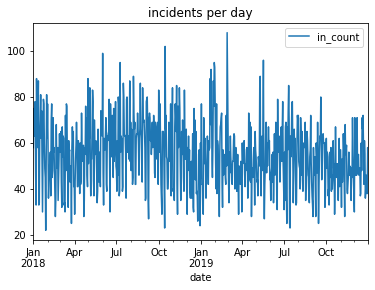

In [13]:
ipd.plot(title='incidents per day')

(array([ 31.,  84., 131., 159., 149., 103.,  44.,  21.,   6.,   2.]),
 array([ 22. ,  30.6,  39.2,  47.8,  56.4,  65. ,  73.6,  82.2,  90.8,
         99.4, 108. ]),
 <BarContainer object of 10 artists>)

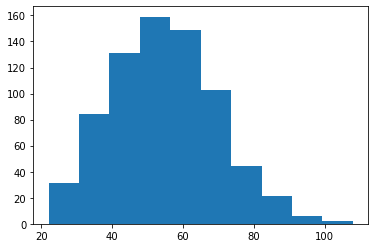

In [14]:
plt.hist(ipd)

The data is normally distributed with a slight right skew. 

In [15]:
# Decompose the data to break down the different components
from statsmodels.tsa.seasonal import seasonal_decompose

In the EDA, I found weekly trends as well as peaks in incidents in the winter and in the summer months.  So when I decompose the data, I explore possible seasonality at the level of a week and at 6-month intervals.

Figure(432x288)


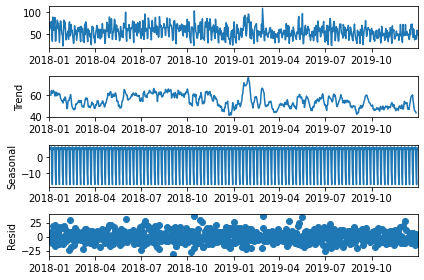

In [16]:
result = seasonal_decompose(ipd, period = 7)
print(result.plot())

Figure(432x288)


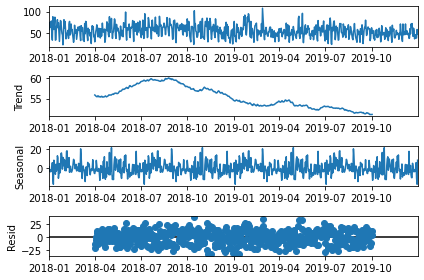

In [17]:
result = seasonal_decompose(ipd, period = 180)
print(result.plot())

I think the weekly period is  relevant to this data, because you can see the regular cycles in the first seasonal plot.  There isn't a clear six month season, so I won't include it in the modelling.  


In [18]:
# Use a dicky fuller test to assess if the data is stationary
from statsmodels.tsa.stattools import adfuller

In [19]:
# create a series for the data values
incidents = ipd['in_count'].values

#ADF test
result=adfuller(incidents, autolag='AIC')
adf_stat, p_value = result[0:2]
print("adf_stat:", adf_stat)
print("p_value:", p_value)
print("the p value is less than 0.05 so the time series is stationary.\nNo transformations are required.")

adf_stat: -3.54216509159344
p_value: 0.006967982668223354
the p value is less than 0.05 so the time series is stationary.
No transformations are required.


Since the data is stationary we don't need to transform it prior to modelling.  

Next look at the ACF and PCF plots to determine if the model should focus on auto regression (AR) or moving averages (MA).  

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Figure(432x288)
Figure(432x288)


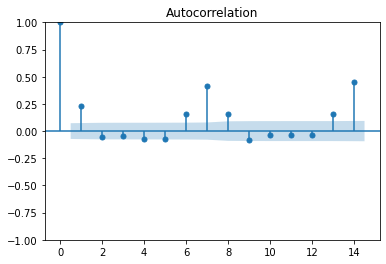

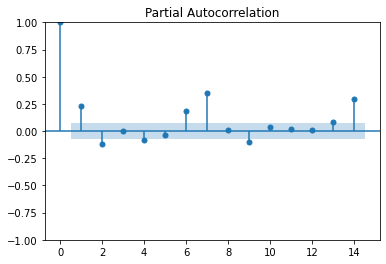

In [21]:
print(plot_acf(ipd['in_count'], lags = 14))
print(plot_pacf(ipd['in_count'],lags=14,method='ywm'))

The autocorreclation plot seems to confirm the weekly trend as the ACF and PCF are significant at 6 and 7 days.This matches with the weekly seasonality seen in the decomposition.  

The ACF plot falls below significance at step 2 before the PACF plot, suggesting that it's mostly an moving average procces at step 2 (MA(2)).

So we'll use an ARMA model (there is no differencing because it's stationary so no 'I' integration term is needed). And while the ACF/PCF plots suggest the types of autoregression and moving averages, let's test out the different combinations to find the optimal parameters.

Split the data into training and testing sets (using 90-10 split).  

In [22]:
# split into train and test
df_train = pd.DataFrame(ipd[:670]).rename(columns={'in_count':'y_train'})
df_test = ipd[670:]


In [23]:
from itertools import product
from tqdm import tqdm_notebook

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox

In [24]:
# I found this function on this blog:
# https://towardsdatascience.com/advanced-time-series-analysis-with-arma-and-arima-a7d9b589ed6d
def optimize_ARIMA(order_list, data):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        data - the data variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = ARIMA(data, order=order).fit() #modified the model to fit what i'm looking for
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
# this code chunk was also modelled on this blog:
# https://towardsdatascience.com/advanced-time-series-analysis-with-arma-and-arima-a7d9b589ed6d

ps = np.arange(1,8)
d=0 #because no differencing is required
qs = np.arange(1,8)

parameters = product(ps, qs)
parameters_list = list(parameters)


order_list = []

#use this to add the 0 to each of the values in the parameter list
for each in parameters_list:
    each = list(each)
    each.insert(1, 0) #this is where you add d=0
    each = tuple(each)
    order_list.append(each)
    

result_df = optimize_ARIMA(order_list, data=df_train['y_train'])

result_df.head(5)

  0%|          | 0/49 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(7, 0, 7)",5218.975858
1,"(6, 0, 7)",5234.531320
2,"(7, 0, 6)",5240.400014
3,"(5, 0, 5)",5244.834756
4,"(5, 0, 6)",5250.018684


The results suggests that an ARMA model with 7 day autoregressions and a 7 day moving average is the best fit. But I ran the top three options ((7,0,7) and (6,0,7) and (7,0,6)) using Ljung-box test and ACF/PACF plots to check the residuals and see which one was really the best for my model.  The residuals for the (7,0,6) appear the most like white noise and had the highest p values.

In [27]:
bestmodel_fit = ARIMA(df_train, order=(7, 0, 6)).fit()
print(bestmodel_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                y_train   No. Observations:                  670
Model:                 ARIMA(7, 0, 6)   Log Likelihood               -2605.200
Date:                Mon, 07 Nov 2022   AIC                           5240.400
Time:                        10:37:45   BIC                           5308.009
Sample:                    01-01-2018   HQIC                          5266.588
                         - 11-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.1907      1.545     35.723      0.000      52.163      58.219
ar.L1          0.8310      0.074     11.176      0.000       0.685       0.977
ar.L2         -0.4924      0.090     -5.455      0.0

In [28]:
# Ljung-Box test
# ljung_box, p_value = 
acorr_ljungbox(bestmodel_fit.resid)
# print(f'Ljung-Box test: {ljung_box[:10]}')
# print(f'p-value: {p_value[:10]}')

,lb_stat,lb_pvalue
1,0.124796,0.723890
2,0.433681,0.805058
3,0.599014,0.896658
4,2.018115,0.732427
5,2.475576,0.780169
6,2.476152,0.871127
7,4.134108,0.764208
8,4.404697,0.818890
9,4.405235,0.882777
10,5.465946,0.857962


None of the values in the Ljung-box test are significant, so we can't reject the null hypothesis, and the residuals aren't correlated.  You can also see in the PACF & ACF of the residuals look like white noise.  

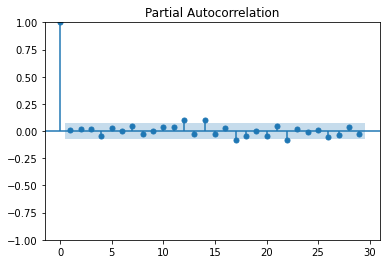

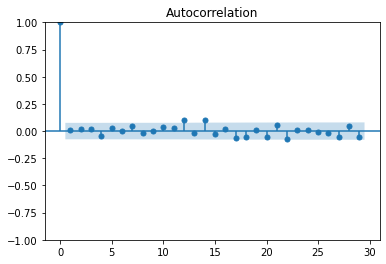

In [29]:
plot_pacf(bestmodel_fit.resid);
plot_acf(bestmodel_fit.resid);

In [30]:
# I modelled the following section off this blog:
# https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html
# Forecast
fcast = bestmodel_fit.forecast('2019-12-31', alpha=0.05)  # 95% conf


In [31]:
# Combine the forcast values with the test values
df_preds = df_test.merge(fcast, how='inner', left_index=True, right_index=True)

In [32]:
# Calculate the test_rmse
rmse = mean_squared_error(df_preds['in_count'].values, df_preds['predicted_mean'].values)
print("RMSE:", rmse)

RMSE: 105.13575848523847


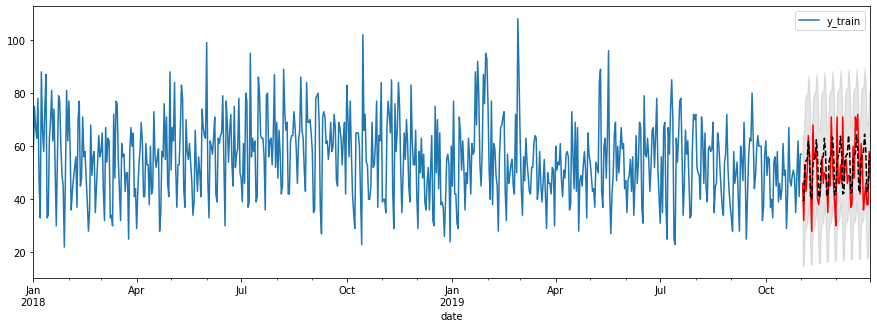

In [33]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
df_train.plot(ax=ax)
df_preds['in_count'].plot(ax=ax, color='red')
# Construct the forecasts
fcast = bestmodel_fit.get_forecast('2019-12-31').summary_frame()
df_preds['predicted_mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

Based on the plot the model seems to be predicting the an increasing number of incidents per day with a regular weekly cycle.  The model doesn't seem to capture either the highs or the lows in the data. 

I'm going to compare this model to a simple linear model that takes similar information into account using generated features with a moving average for the past 7 days and a series of one-hot-encoded variables that shows the day of the week.  

In [34]:
from sklearn.linear_model import LinearRegression
import calendar

In [35]:
# create a rolling average
X_ma = ipd.rolling(window=7).mean()
# create a copy to the series
X_dow = ipd.copy()
# create a new variable for day of week (dow)
X_dow['dow'] = X_dow.index.day_name()
X_dow = pd.get_dummies(X_dow['dow'])

# combine the features into a data frame and drop the rows with na
df_features = pd.merge(X_ma, X_dow, left_index=True, right_index=True).dropna()

# combined y and X_features into one df to be 
df_features = pd.merge(df_features, ipd.rename(columns={'in_count':'y'}), left_index=True, right_index=True).rename(columns = {'in_count':'ma'})
df_features.head()

,ma,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,y
date,,,,,,,,,
2018-01-07,60.142857,0,0,0,1,0,0,0,33
2018-01-08,64.428571,0,1,0,0,0,0,0,88
2018-01-09,63.142857,0,0,0,0,0,1,0,66
2018-01-10,61.857143,0,0,0,0,0,0,1,58
2018-01-11,63.428571,0,0,0,0,1,0,0,74


In [36]:
# split into train and test
df_train = pd.DataFrame(df_features[:579])
df_test = df_features[579:]

X_train = df_train.iloc[:,:-1]
X_test = df_test.iloc[:,:-1]

y_train = df_train.iloc[:,-1]
y_test  = df_test.iloc[:,-1]

In [37]:
model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_test), index=X_test.index).clip(0.0)

rmsle_train = mean_squared_error(y_train, y_fit) 
rmsle_test = mean_squared_error(y_test, y_pred)

print(f'Training RMSE: {rmsle_train:.5f}')
print(f'Validation RMSE: {rmsle_test:.5f}')

Training RMSE: 111.37320
Validation RMSE: 72.53025


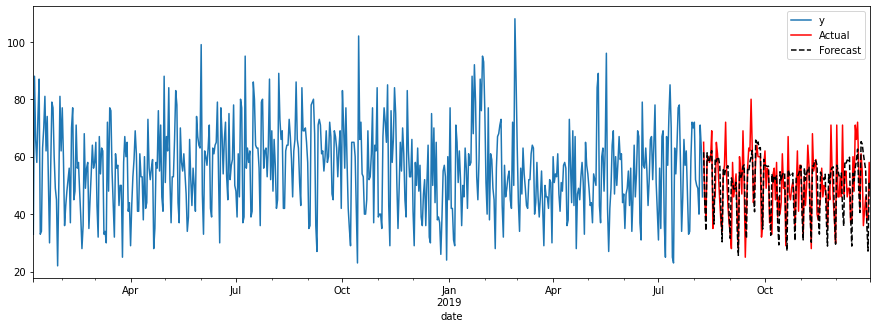

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))

y_train.plot(ax=ax)
y_test.plot(ax=ax, label="Actual", color='red')
y_pred.plot(ax=ax, label="Forecast", style='k--')
ax.legend();

A linear regression model using the moving average of the past week as well as day of the week features does a better job than the best fit ARMA model at predicting incidents per day.  The root mean square error of the linear model was 72.53 compared to 105.14 for the ARMA model.

The visualization of the linear model's predictions shows the model does a better job at predicting the days with average or below average incidents. The days with large numbers of incidents are not predicted as well.  

# Conclusion

I would recommend using the linear model for predicting staffing or planning your events using the TTC. To improve the model further additional exploration of the characteristics of the high incident days, may help identify additional features to layer into the model.  In addition to features in the current data set such as type and location, I could look to incorporate in weather data which may be related to incidents particularly on surface routes or to incorporate usage data as incidents may be more likely on days with higher passenger volume.  